In [3]:
# import the pytorch library into environment and check its version
import os
import torch
import numpy as np
print("Using torch", torch.__version__)

Using torch 2.5.1+cu121


In [39]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.4.1+cu118.html
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
from torch_geometric import nn
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
import torch.optim as optim
import torch.nn as nn



Looking in links: https://data.pyg.org/whl/torch-2.4.1+cu118.html


In [40]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.layer1 = GCNConv(in_channels, hidden_channels, normalize=True)
        self.relu = torch.nn.ReLU()
        self.layer2 = GCNConv(hidden_channels, hidden_channels, normalize=True)
        self.relu = torch.nn.ReLU()
        self.layer3 = GCNConv(hidden_channels, out_channels, normalize=True)

    def forward(self, node_features, edge_list):
      intermediate = self.layer1(node_features, edge_list)
      intermediate = self.relu(intermediate)
      intermediate = self.layer2(intermediate, edge_list)
      intermediate = self.relu(intermediate)
      output = self.layer3(intermediate, edge_list)
      return output

def train(model, data, optimizer, loss_fn):
  loss = 0

  model.train()
  optimizer.zero_grad()
  y_pred = model(data.x, data.edge_index)

  loss = loss_fn(y_pred[train_mask], data.y[train_mask])
  loss.backward()
  optimizer.step()


  return loss


@torch.no_grad()

def calculate_accuracy(pred, label):

  acc = 0.0


  predictions = torch.argmax(pred, dim = 1)
  correct = (predictions == label)
  acc  = correct.sum()/label.numel()

  return acc



def test(model, data):

    accuracy_list = [0, 0, 0]


    model.eval()
    y_pred = model(data.x, data.edge_index)
    train_pred = y_pred[train_mask]
    valid_pred = y_pred[val_mask]
    test_pred = y_pred[test_mask]
    train_correct = data.y[train_mask]
    valid_correct = data.y[val_mask]
    test_correct = data.y[test_mask]

    accuracy_list[0] = calculate_accuracy(train_pred, train_correct)
    accuracy_list[1] = calculate_accuracy(valid_pred, valid_correct)
    accuracy_list[2] = calculate_accuracy(test_pred, test_correct)

    return accuracy_list








In [53]:
edge_list = np.load("edge_list.npy")
edge_list = edge_list.astype(np.int64)
edge_list = torch.from_numpy(edge_list)

node_features = np.load("standardized_feature_vectors.npy")
node_features = node_features.astype(np.float32)
node_features = torch.from_numpy(node_features)

labels = torch.from_numpy(np.load("labels.npy"))

data = Data(x = node_features, edge_index = edge_list, y=labels)

print(data.x.dtype, data.edge_index.dtype, data.y.dtype)
num_nodes = data.x.shape[0]
print(data.x.shape[0])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
for i in range(0, num_nodes):
  if i < 12000:
    train_mask[i] = True
  else:
    train_mask[i] = False

val_mask = torch.zeros(num_nodes, dtype=torch.bool)
for i in range(0, num_nodes):
  if i >= 12000 and i < 16000:
    val_mask[i] = True
  else:
    val_mask[i] = False


test_mask = torch.zeros(num_nodes, dtype=torch.bool)
for i in range(0, num_nodes):
  if i >= 16000:
    test_mask[i] = True
  else:
    test_mask[i] = False



print(train_mask)





train_node_feature = node_features[train_mask]
valid_node_feature = node_features[val_mask]
test_node_feature = node_features[test_mask]

print("number of nodes in train set,", train_node_feature.shape[0])
print("number of nodes in valid set,", valid_node_feature.shape[0])
print("number of nodes in test set,", test_node_feature.shape[0])




GCN_model = GCN(data.x.shape[1], 32, 8)

optimizer = optim.Adam(GCN_model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()


epochs = 10
best_val_acc = final_test_acc = 0
for epoch in range(1, epochs + 1):
    loss = train(GCN_model, data, optimizer, loss_fn)
    train_acc, val_acc, test_acc = test(GCN_model, data)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        final_test_acc = test_acc
print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))








torch.float32 torch.int64 torch.int64
19240
tensor([ True,  True,  True,  ..., False, False, False])
number of nodes in train set, 12000
number of nodes in valid set, 4000
number of nodes in test set, 3240
after 50 epochs' training, the best test accuracy is 0.182407408952713


In [55]:
import pandas as pd
import matplotlib.pyplot as plt

learning_rates = [1e-3, 1e-4, 1e-5, 1e-6]
epochs_list = [10, 20, 40, 60, 80, 100]
optimizers = [optim.Adam, optim.SGD, optim.SGD]  # Add more optimizers as needed
optimizer_names = ['Adam', 'SGD', 'Nesterov']  # Match optimizer list

columns = ['Learning Rate', 'Epochs', 'Optimizer', 'Final Test Accuracy']
results_df = pd.DataFrame(columns=columns)


for lr in learning_rates:
    for epochs in epochs_list:
        for opt, opt_name in zip(optimizers, optimizer_names):
            model = GCN(data.x.shape[1], 32, 8)
            loss_fn = nn.CrossEntropyLoss()
            best_val_acc = final_test_acc = 0

            optimizer = opt(model.parameters(), lr=lr)

            for epoch in range(1, epochs + 1):
              loss = train(model, data, optimizer, loss_fn)
              train_acc, val_acc, test_acc = test(model, data)
              if val_acc > best_val_acc:
                  best_val_acc = val_acc
                  final_test_acc = test_acc



            new_row = pd.DataFrame({'Learning Rate': [lr],
                                    'Epochs': [epochs],
                                    'Optimizer': [opt_name],
                                    'Final Test Accuracy': [final_test_acc]})
            results_df = pd.concat([results_df, new_row], ignore_index=True)



<ipython-input-55-30a79d94d72c>:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


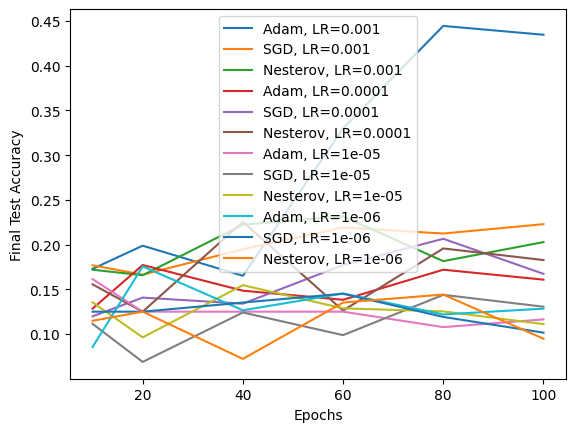

In [56]:
for lr in learning_rates:
    for opt_name in optimizer_names:
        subset_df = results_df[(results_df['Learning Rate'] == lr) & (results_df['Optimizer'] == opt_name)]
        plt.plot(subset_df['Epochs'], subset_df['Final Test Accuracy'], label=f'{opt_name}, LR={lr}')

plt.xlabel('Epochs')
plt.ylabel('Final Test Accuracy')
plt.legend()
plt.show()

In [60]:

for i in range(0, 10):

  GCN_model = GCN(data.x.shape[1], 32, 8)

  optimizer = optim.Adam(GCN_model.parameters(), lr=1e-3)
  loss_fn = nn.CrossEntropyLoss()


  epochs = 80
  best_val_acc = final_test_acc = 0
  best_epoch = 0

  for epoch in range(1, epochs + 1):
      loss = train(GCN_model, data, optimizer, loss_fn)
      train_acc, val_acc, test_acc = test(GCN_model, data)
      if val_acc > best_val_acc:
          best_val_acc = val_acc
          final_test_acc = test_acc
          best_epoch = epoch
  print("best epoch: ", best_epoch)
  print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))



for i in range(0,10):
  optimizer = optim.Adam(GCN_model.parameters(), lr=1e-3)
  loss_fn = nn.CrossEntropyLoss()


  epochs = 90
  best_val_acc = final_test_acc = 0
  best_epoch = 0

  for epoch in range(1, epochs + 1):
      loss = train(GCN_model, data, optimizer, loss_fn)
      train_acc, val_acc, test_acc = test(GCN_model, data)
      if val_acc > best_val_acc:
          best_val_acc = val_acc
          final_test_acc = test_acc
          best_epoch = epoch
  print("best epoch: ", best_epoch)
  print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))


best epoch:  80
after 80 epochs' training, the best test accuracy is 0.33364197611808777
best epoch:  80
after 80 epochs' training, the best test accuracy is 0.33981481194496155
best epoch:  80
after 80 epochs' training, the best test accuracy is 0.3978395164012909
best epoch:  80
after 80 epochs' training, the best test accuracy is 0.3787037134170532
best epoch:  80
after 80 epochs' training, the best test accuracy is 0.3790123462677002
best epoch:  80
after 80 epochs' training, the best test accuracy is 0.40802469849586487
best epoch:  80
after 80 epochs' training, the best test accuracy is 0.3521604835987091
best epoch:  80
after 80 epochs' training, the best test accuracy is 0.39135801792144775
best epoch:  80
after 80 epochs' training, the best test accuracy is 0.3459876477718353
best epoch:  80
after 80 epochs' training, the best test accuracy is 0.39413580298423767
best epoch:  55
after 90 epochs' training, the best test accuracy is 0.48580247163772583
best epoch:  25
after 90 e

In [63]:
for i in range(0, 10):

  GCN_model = GCN(data.x.shape[1], 32, 8)

  optimizer = optim.Adam(GCN_model.parameters(), lr=1e-3)
  loss_fn = nn.CrossEntropyLoss()


  epochs = 90
  best_val_acc = final_test_acc = 0
  best_epoch = 0

  for epoch in range(1, epochs + 1):
      loss = train(GCN_model, data, optimizer, loss_fn)
      train_acc, val_acc, test_acc = test(GCN_model, data)
      if val_acc > best_val_acc:
          best_val_acc = val_acc
          final_test_acc = test_acc
          best_epoch = epoch
  print("best epoch: ", best_epoch)
  print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))


for i in range(0, 10):

  GCN_model = GCN(data.x.shape[1], 32, 8)

  optimizer = optim.Adam(GCN_model.parameters(), lr=1e-3)
  loss_fn = nn.CrossEntropyLoss()


  epochs = 100
  best_val_acc = final_test_acc = 0
  best_epoch = 0

  for epoch in range(1, epochs + 1):
      loss = train(GCN_model, data, optimizer, loss_fn)
      train_acc, val_acc, test_acc = test(GCN_model, data)
      if val_acc > best_val_acc:
          best_val_acc = val_acc
          final_test_acc = test_acc
          best_epoch = epoch
  print("best epoch: ", best_epoch)
  print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))

for i in range(0, 10):

  GCN_model = GCN(data.x.shape[1], 32, 8)

  optimizer = optim.Adam(GCN_model.parameters(), lr=1e-3)
  loss_fn = nn.CrossEntropyLoss()


  epochs = 150
  best_val_acc = final_test_acc = 0
  best_epoch = 0

  for epoch in range(1, epochs + 1):
      loss = train(GCN_model, data, optimizer, loss_fn)
      train_acc, val_acc, test_acc = test(GCN_model, data)
      if val_acc > best_val_acc:
          best_val_acc = val_acc
          final_test_acc = test_acc
          best_epoch = epoch
  print("best epoch: ", best_epoch)
  print("after {} epochs' training, the best test accuracy is {}".format(epochs, final_test_acc))

best epoch:  90
after 90 epochs' training, the best test accuracy is 0.3679012358188629
best epoch:  89
after 90 epochs' training, the best test accuracy is 0.4432098865509033
best epoch:  89
after 90 epochs' training, the best test accuracy is 0.404938280582428
best epoch:  88
after 90 epochs' training, the best test accuracy is 0.46481481194496155
best epoch:  89
after 90 epochs' training, the best test accuracy is 0.4472222328186035
best epoch:  89
after 90 epochs' training, the best test accuracy is 0.4067901372909546
best epoch:  90
after 90 epochs' training, the best test accuracy is 0.3731481432914734
best epoch:  90
after 90 epochs' training, the best test accuracy is 0.35061728954315186
best epoch:  88
after 90 epochs' training, the best test accuracy is 0.3669753074645996
best epoch:  90
after 90 epochs' training, the best test accuracy is 0.4009259343147278
best epoch:  100
after 100 epochs' training, the best test accuracy is 0.41635802388191223
best epoch:  100
after 100 e